<a href="https://colab.research.google.com/github/EsserMishelle/short-term-stock-forecast/blob/main/02_arima_univariate_price_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
The objective of this project is to forecast the short-term closing price of NVIDIA (NVDA) stock using classical time-series models and compare their performance using information criteria and forecast accuracy.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load NVDA price and volume and merge them together

In [3]:
# --- Load the price file ---
price_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

# Filter out only 'Close' related columns
close_df = price_df.filter(like='_Close').copy()

# Remove caret^ and lowercase column names
close_df.columns = (
    close_df.columns
        .str.replace('^', '', regex=False)   # remove caret ^
        .str.lower()
)

# Flatten multi-index columns
close_df.columns = [
    '_'.join(col).strip() if isinstance(col, tuple) else col
    for col in close_df.columns
]

display(close_df.info())
print()

display(close_df.describe())
print()

display(close_df.head())
print()
display(close_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   qqq_close   1278 non-null   float64
 1   nvda_close  1278 non-null   float64
 2   amd_close   1278 non-null   float64
 3   tnx_close   1278 non-null   float64
 4   vix_close   1278 non-null   float64
 5   tsm_close   1278 non-null   float64
dtypes: float64(6)
memory usage: 69.9 KB


None

,qqq_close,nvda_close,amd_close,tnx_close,vix_close,tsm_close
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000
mean,403.124009,69.329726,123.029421,3.384294,19.287801,137.752928
std,101.989703,59.103824,42.477132,1.146447,5.260509,64.525107
min,255.265457,11.212904,55.939999,0.917000,11.860000,57.205883
25%,319.557510,19.515135,90.902502,2.644500,15.625000,90.165972
50%,369.977707,42.327452,112.084999,3.878500,17.995000,110.398640
75%,479.328468,121.585546,150.435001,4.258000,21.889999,172.072079
max,634.951965,207.028473,264.329987,4.988000,52.330002,342.399994


,qqq_close,nvda_close,amd_close,tnx_close,vix_close,tsm_close
Date,,,,,,
2021-01-04,300.163147,13.076726,92.300003,0.917,26.969999,102.714417
2021-01-05,302.637726,13.367159,92.769997,0.955,25.340000,103.698318
2021-01-06,298.445557,12.579123,90.330002,1.042,25.070000,106.309875
2021-01-07,305.665466,13.306580,95.160004,1.071,22.370001,111.661705
2021-01-08,309.595703,13.239516,94.580002,1.105,21.559999,109.142120


,qqq_close,nvda_close,amd_close,tnx_close,vix_close,tsm_close
Date,,,,,,
2026-01-29,629.429993,192.509995,252.179993,4.227,16.879999,339.549988
2026-01-30,621.869995,191.130005,236.729996,4.241,17.440001,330.559998
2026-02-02,626.140015,185.610001,246.270004,4.275,16.340000,341.359985
2026-02-03,616.520020,180.339996,242.110001,4.274,18.000000,335.750000
2026-02-04,605.750000,174.190002,200.190002,4.275,18.639999,325.739990


### The result shows the DataFrame has 1278 entries and 6 columns with no null values.

In [4]:
# # Divide the stocks DataFrame by TICKER and duplicate it.
nvda = close_df[['nvda_close']].copy()
amd = close_df[['amd_close']].copy()
tsm = close_df[['tsm_close']].copy()
qqq = close_df[['qqq_close']].copy()

# All indices are sorted chronologically to preserve temporal order.
nvda = nvda.sort_index()
amd = amd.sort_index()
tsm = tsm.sort_index()
qqq = qqq.sort_index()

## Define the prediction task

This project focuses on classical time-series forecasting methods demonstrated in class, comparing ARIMA, Prophet, and linear trend models using AIC and forecast error metrics.

In [5]:
# Predict whether NVDA’s 5-day return exceeds a minimum meaningful threshold.

# threshold = 0.01 #(1%)

# nvda['future_return_5d'] = nvda['Close'].pct_change(5).shift(-5)
# nvda['target'] = (nvda['future_return_5d'] > threshold).astype(int)
# nvda

# nvda['target'].value_counts(normalize=True)

In [6]:
arima_ts = nvda['nvda_close']
arima_ts.index = pd.to_datetime(arima_ts.index) # Make sure arima_ts has a datetime index
arima_ts = arima_ts.asfreq('B') # Only business work days (M-F)
arima_ts

,nvda_close
Date,
2021-01-04,13.076726
2021-01-05,13.367159
2021-01-06,12.579123
2021-01-07,13.306580
2021-01-08,13.239516
...,...
2026-01-29,192.509995
2026-01-30,191.130005
2026-02-02,185.610001


## ARIMA (Autoregressive Integrated Moving Average)

### The ARIMA (Autoregressive Integrated Moving Average) model is a commonly used approach for forecasting time-series data. It works by combining information from past values of the series, changes between observations, and past forecast errors to model the underlying structure of the data. By incorporating **autoregression (AR), differencing (I), and moving-average terms (MA)**, ARIMA is able to capture trends and short-term patterns in historical data and use them to generate future forecasts.




## Choose Model (in-sample)
### ADF Differencing
#### Because ARIMA models require a stationary time series, the stationarity of the NVDA closing price data is first evaluated using the **Augmented Dickey–Fuller (ADF)** test. The ADF test checks for the presence of a unit root, where a failure to reject the null hypothesis indicates non-stationarity and the need for differencing before model fitting.

The test result shows the p-value (.97) is > .05 and the test statistic is above all critical values, so it fails to reject the null hypothesis. In other words, NVDA closing pric series is non-stationary.

To address this, first differencing is applied, which removes trend effects by modeling changes between consecutive observations rather than absolute price levels.

In [7]:
adfuller(arima_ts.diff().dropna())
print(adfuller(arima_ts.diff().dropna())[1])

1.3077880738797484e-07


After differencing, the ADF test strongly rejected the null hypothesis (p < 0.001) and that the transformed series now is stationary.
This proves that the first differencing is required to satisfy the assumptions of ARIMA modeling, corresponding to d = 1 in the ARIMA(p, d, q) specification.

### Autoregressive (AR) Models - obtain d

In [8]:
arima_ts_diff = arima_ts.diff().dropna()
arima_ts_diff

,nvda_close
Date,
2021-01-05,0.290433
2021-01-06,-0.788035
2021-01-07,0.727456
2021-01-08,-0.067063
2021-01-11,0.343786
...,...
2026-01-29,0.989990
2026-01-30,-1.379990
2026-02-02,-5.520004


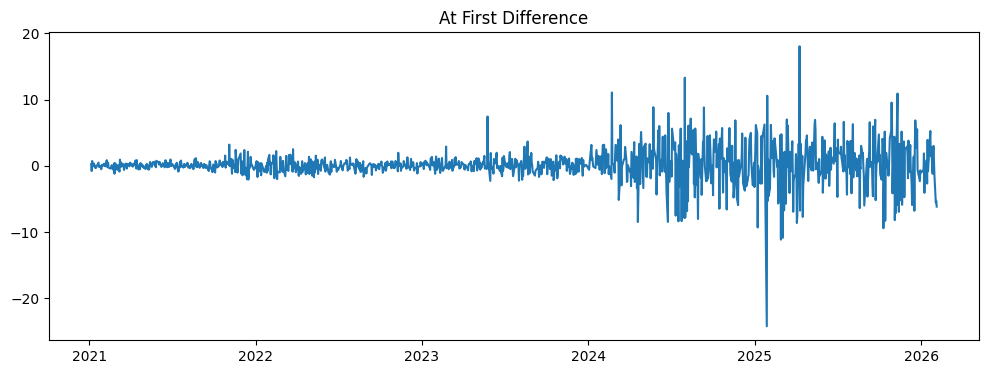

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(arima_ts_diff)
plt.title('At First Difference')
plt.show()

## ACF/PACF - Candidate p, q

Text(0, 0.5, 'Correlation')

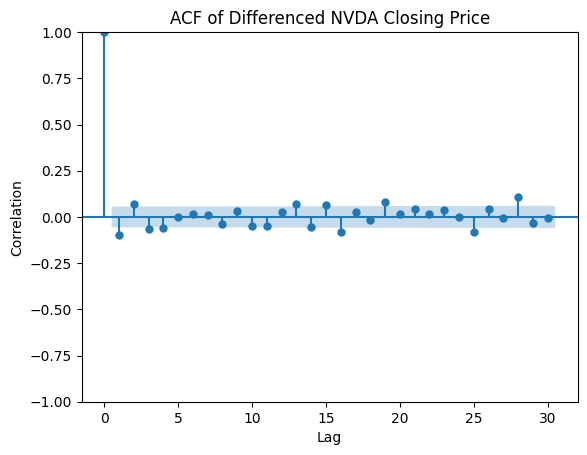

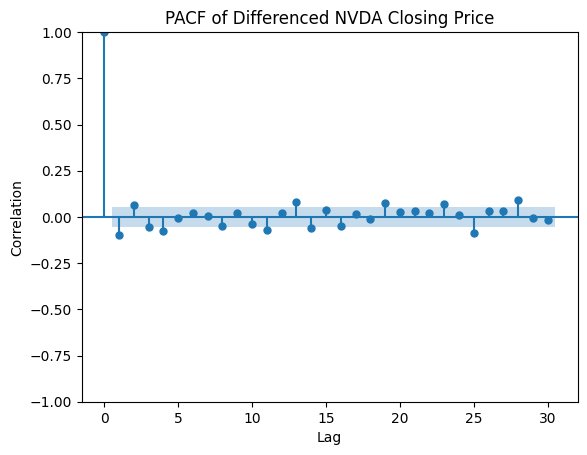

In [10]:
plot_acf(arima_ts_diff, lags=30)
plt.title('ACF of Differenced NVDA Closing Price')
plt.xlabel('Lag')
plt.ylabel('Correlation')

plot_pacf(arima_ts_diff, lags=30)
plt.title('PACF of Differenced NVDA Closing Price')
plt.xlabel('Lag')
plt.ylabel('Correlation')


###* ACF Plot Interpretation:
* Low Autocorrelation: Since all lag correlations are close to zero, this suggests that the series is likely to be white noise or has very short memory. There are no lags showing significant autocorrelation.
* Model Implications: If ACF does not show significant spikes, it indicates that you might consider a lower or possibly no moving average (MA) component.

### Interpretation of the ACF Plot:
Low Autocorrelation: Since all lag correlations are close to zero, this suggests that the series is likely to be white noise or has very short memory. There are no lags showing significant autocorrelation.
*Model Implications: If ACF does not show significant spikes, it indicates that you might consider a lower or possibly no moving average (MA) component.

After first differencing, both the ACF and PACF exhibit minimal autocorrelation, with no strong spikes beyond lag 1. This indicates that the differenced series behaves similarly to white noise, which is typical for financial return data. A parsimonious ARIMA(1,1,1) model is therefore selected to capture any remaining short-term dependence.

## AIC Grid Search - to obtain p, d, q

In [11]:
# from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_order = None

# convert ts to only use business days
# ts = ts.asfreq('B')  # business days

# for the AR compnent (p)
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(arima_ts, trend='t', order=(p,1,q)) # Add a trend element
            fit = model.fit()
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_order = (p,1,q)
        except:
            continue

print("Best:", best_order, "AIC:", best_aic)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best: (4, 1, 4) AIC: 6018.641302941969


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


While ARIMA(4,1,4) achieved the lowest AIC, a simpler ARIMA(1,1,1) model was selected due to its interpretability and stability, given the weak autocorrelation structure of the differenced series.

Best model = ARIMA(4, 1, 4)

## Refit the Model Using Only the Training Data
### Train-Test-Split

In [12]:
# Test for one full year
split_date = '02-03-2025' # First business date in Feb 2025

arima_train = arima_ts[arima_ts.index < split_date]
arima_test =  arima_ts[arima_ts.index >= split_date]


### ARIMA Fit Train Data Only

In [13]:
arima_train_model = ARIMA(arima_train, order =(4,1,4), trend='t')
arima_train_fit= arima_train_model.fit()
arima_train_fit.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             nvda_close   No. Observations:                 1065
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -2201.369
Date:                Mon, 16 Feb 2026   AIC                           4422.738
Time:                        18:06:48   BIC                           4472.436
Sample:                    01-04-2021   HQIC                          4441.570
                         - 01-31-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1054      0.114      0.925      0.355      -0.118       0.329
ar.L1          0.0956      0.097      0.987      0.324      -0.094       0.285
ar.L2          1.3700      0.076     18.119      0.000       1.222       1.518
ar.L3          0.3557      0.072      4.927      0.000       0.214       0.497
ar.L4         -0.8250      0.095     -8.668      0.000      -1.012      -0.638
ma.L1         -0.1436      0.092     -1.563      0.118      -0.324       0.036
ma.L2         -1.3434      0.068    -19.704      0.000      -1.477      -1.210
ma.L3         -0.3672      0.069     -5.312      0.000      -0.503      -0.232
ma.L4          0.8578      0.090      9.578      0.000       0.682       1.033
sigma2         4.1505      0.095     43.518      0.000       3.964       4.337
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             18502.40
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              19.15   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnostic Check (still in-sample)
## Chart fit.resid

In [14]:
resid = arima_train_fit.resid.dropna()
resid

,0
Date,
2021-01-04,12.971346
2021-01-05,0.185061
2021-01-06,-0.867672
2021-01-07,0.493897
2021-01-08,-0.032768
...,...
2025-01-27,-22.471387
2025-01-28,7.057735
2025-01-29,-2.442892


#### The residual dignostic chart checks training assumptions and validate the residual patterns are just white noise and that (4, 1,4) is not underfitting

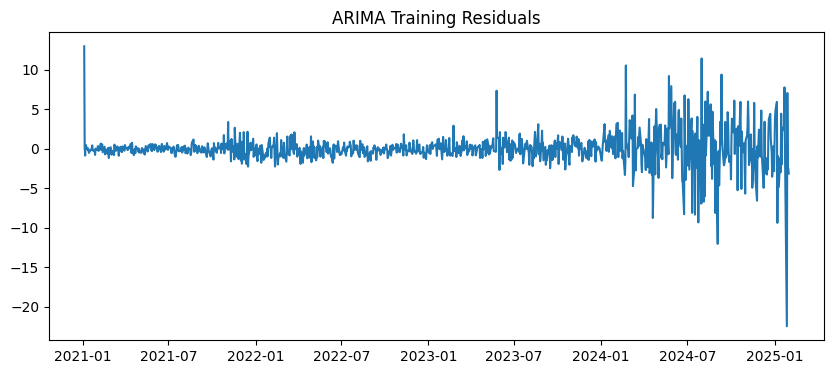

In [15]:
plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title('ARIMA Training Residuals')
plt.show()

## Plot acf and pact of fit.resid

<Figure size 1000x400 with 0 Axes>

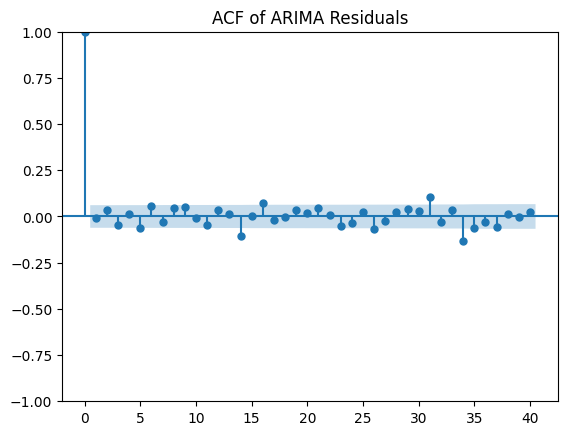

<Figure size 1000x400 with 0 Axes>

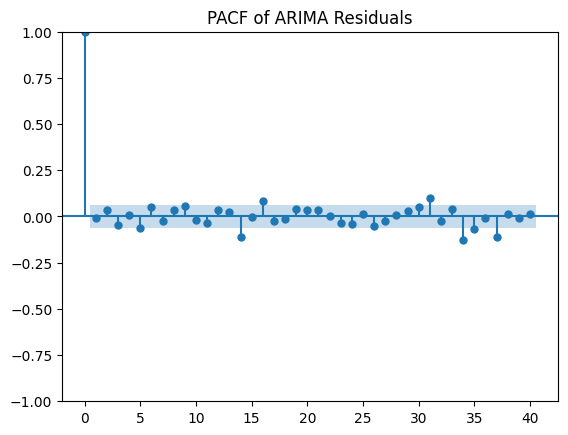

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plot_acf(resid, lags=40)
plt.title('ACF of ARIMA Residuals')
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(resid, lags=40)
plt.title('PACF of ARIMA Residuals')
plt.show()

In [17]:
forecast = arima_train_fit.get_forecast(steps=len(arima_test))
pred = forecast.predicted_mean
pred


,predicted_mean
2025-02-03,120.990401
2025-02-04,122.478103
2025-02-05,120.504934
2025-02-06,123.838692
2025-02-07,121.197362
...,...
2026-01-29,150.067598
2026-01-30,149.629962
2026-02-02,150.218132
2026-02-03,150.016314


In [18]:
print(f'arima_test has: {arima_test.isnull().sum()} NaNs')
print(f'pred has: {pred.isnull().sum()} NaNs')

# arima_test set has NaN because of market holidays.
# pred has no NaNs because ARIMA predicts every step

arima_test_clean = arima_test.dropna()
pred_clean = pred.loc[arima_test_clean.index]


arima_test has: 10 NaNs
pred has: 0 NaNs


### Remove market holidays from ARIMA train dataset

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_arima(train, test, fit, model_name='ARIMA'):

    # ----- In-sample -----
    train_pred = fit.fittedvalues
    train_eval = pd.concat([train, train_pred], axis=1).dropna()
    train_eval.columns = ['actual', 'pred']

    # ----- Out-of-sample -----
    forecast = fit.get_forecast(steps=len(test))
    test_pred = forecast.predicted_mean

    test_eval = pd.concat([test, test_pred], axis=1).dropna()
    test_eval.columns = ['actual', 'pred']

    # ----- Metrics -----
    results = {
        'Model': model_name,
        'Train_MAE': mean_absolute_error(train_eval['actual'], train_eval['pred']),
        'Test_MAE': mean_absolute_error(test_eval['actual'], test_eval['pred']),
        'Train_RMSE': np.sqrt(mean_squared_error(train_eval['actual'], train_eval['pred'])),
        'Test_RMSE': np.sqrt(mean_squared_error(test_eval['actual'], test_eval['pred'])),
        'Train_MAPE': mean_absolute_percentage_error(train_eval['actual'], train_eval['pred']),
        'Test_MAPE': mean_absolute_percentage_error(test_eval['actual'], test_eval['pred'])
    }

    return pd.DataFrame([results])


In [20]:
arima_metrics_export = evaluate_arima(
    arima_train,
    arima_test,
    arima_train_fit,
    model_name='ARIMA'
)

display(arima_metrics_export)

,Model,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE
0,ARIMA,1.190919,28.396711,2.122028,32.110362,0.026627,0.171288


In [21]:
import os

folder_path = '/content/drive/MyDrive/stocks'
os.makedirs(folder_path, exist_ok=True)

print("Folder ready:", folder_path)

file_path = os.path.join(folder_path, 'arima_metrics.csv')
arima_metrics_export.to_csv(file_path, index=False)

print("Saved to:", file_path)

Folder ready: /content/drive/MyDrive/stocks
Saved to: /content/drive/MyDrive/stocks/arima_metrics.csv


## Get ARIMA forecast for the full dataset

In [22]:
arima_full_model = ARIMA(
    arima_ts,
    order=(4,1,4),   # use the order you selected
    trend='t'
)

arima_full_fit = arima_full_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecast next 30 business days

In [23]:
arima_forecast_30 = arima_full_fit.get_forecast(steps=30)
pred_30 = arima_forecast_30.predicted_mean
ci_30 = arima_forecast_30.conf_int()


In [24]:
pred_30

,predicted_mean
2026-02-05,174.383518
2026-02-06,174.423142
2026-02-09,175.610622
2026-02-10,175.731829
2026-02-11,175.486244
2026-02-12,176.026368
2026-02-13,176.667737
2026-02-16,176.412269
2026-02-17,176.417278
2026-02-18,177.067672


Plot 2021-2026 + Forecast

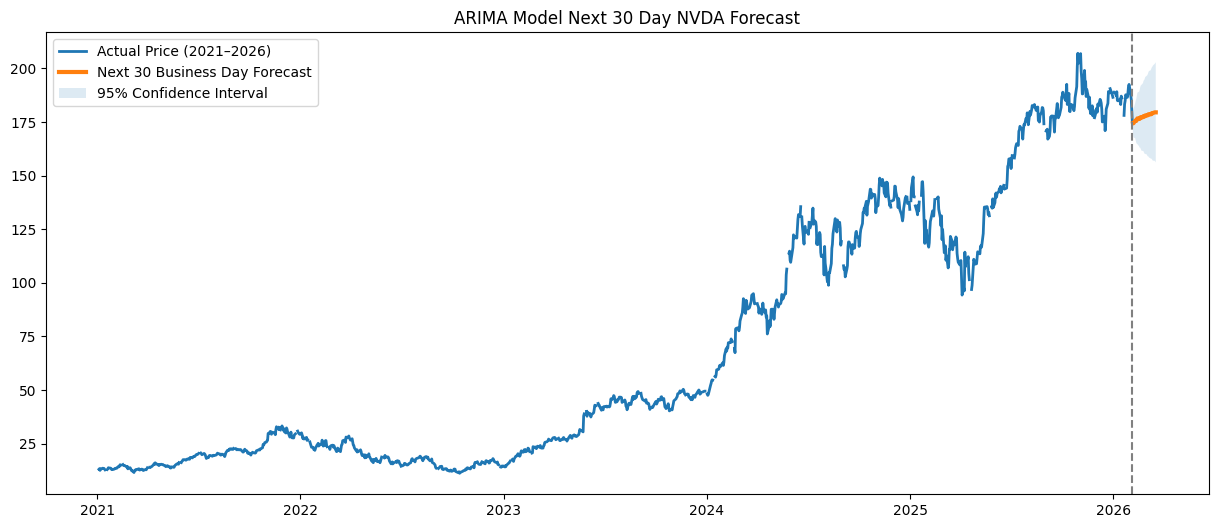

In [25]:
plt.figure(figsize=(15,6))

plt.plot(arima_ts, label='Actual Price (2021–2026)',  linewidth=2)
plt.plot(pred_30, label='Next 30 Business Day Forecast', linewidth=3)
plt.fill_between(
    ci_30.index,
    ci_30.iloc[:,0],
    ci_30.iloc[:,1],
    alpha=0.15,
    label='95% Confidence Interval',
)
plt.axvline(arima_ts.index[-1], linestyle='--', color='gray')
# plt.xlim(arima_ts.index[0], pred_30.index[-1])
plt.legend()
plt.title('ARIMA Model Next 30 Day NVDA Forecast')
plt.show()

Business days only and next trading day are applied to see the next 30 days forecase along with the last 90 days trend.

Plot ZOOMED view (last 90 days + 30 days prediction)

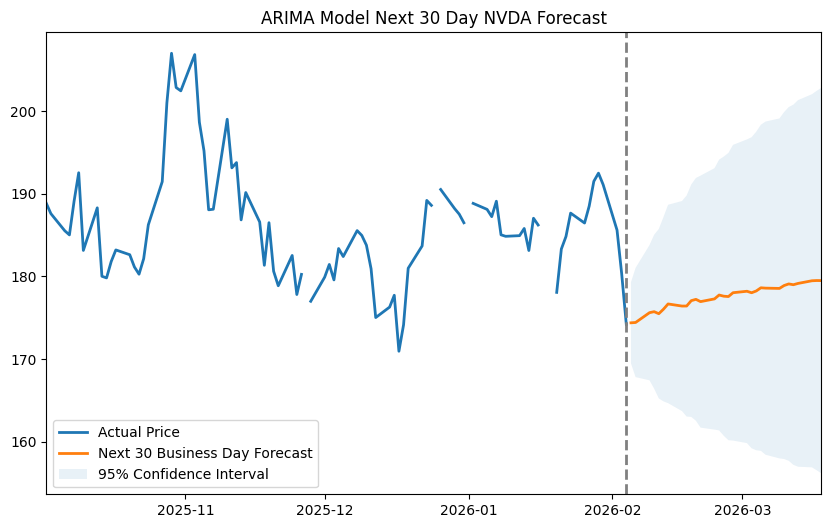

In [26]:
start_zoom = arima_ts.index[-90]
end_zoom = ci_30.index[-1]

plt.figure(figsize=(10,6))

plt.plot(
    arima_ts.loc[start_zoom:],
    label ='Actual Price',
    linewidth=2
)

plt.plot(
    pred_30, label='Next 30 Business Day Forecast',  linewidth=2)

plt.fill_between(
    ci_30.index,
    ci_30.iloc[:,0],
    ci_30.iloc[:,1],
    alpha=.10,
    label='95% Confidence Interval',
)
plt.axvline(arima_ts.index[-1], linestyle='--', color='gray', linewidth=2)

plt.xlim(start_zoom, end_zoom)

plt.legend()
plt.title('ARIMA Model Next 30 Day NVDA Forecast')
plt.show()

## An ARIMA(3,1,3) model with a drift term was also evaluated to account for persistent upward movement in the series. While the drift-adjusted model produces a modest upward forecast, it remains conservative and does not extrapolate recent price spikes. This behavior is consistent with financial theory, where short-term stock price movements are largely unpredictable and best modeled as a random walk with drift.



---

